# Imports


In [1]:
# %tensorflow_version 2.x

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


# Organizing Directory System

In [0]:
os. getcwd()

In [0]:
main_dir = os.getcwd()

# Data loading and preprocessing

In [0]:
path = os.path.join(main_dir, 'mnist.csv')
mnist = pd.read_csv(path)

### Confirming the dataframe columns

In [5]:
mnist.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

### Reshaping

The inputs are reshaped back to image dimensions and the outputs are confirmed to be in integer format.

In [0]:
X = np.array(mnist.iloc[:,1:]).reshape((-1,28,28,1))
Y = np.array(mnist.iloc[:,0]).reshape((-1,1))

In [7]:
X.shape, Y.shape

((42000, 28, 28, 1), (42000, 1))

In [8]:
set(mnist['label'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

### Analysing distribution of classes in data

Its uniformly distributed among all classes

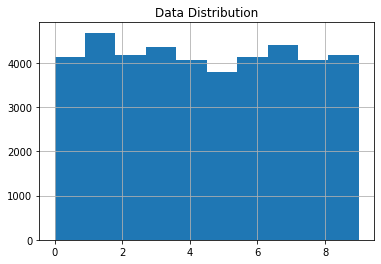

In [9]:
_ = pd.DataFrame(Y).hist()
_ = plt.title('Data Distribution')

### Stratified Spliting

Stratified split and distribution confirmed to be uniform

In [0]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=123)
for train_index, valid_index in sss.split(X, Y):
  X_train, X_valid = X[train_index], X[valid_index]
  Y_train, Y_valid = Y[train_index], Y[valid_index]

In [11]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((29400, 28, 28, 1), (29400, 1), (12600, 28, 28, 1), (12600, 1))

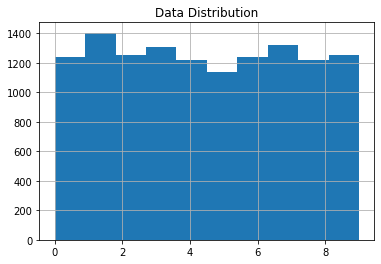

In [12]:
_ = pd.DataFrame(Y_valid).hist()
_ = plt.title('Data Distribution')

### Image Augmentation and Visualization

To increase capacity of model indirectly and add variability to the model learning features

In [0]:
image_gen_train = ImageDataGenerator(
                                      rotation_range=30,  
                                      zoom_range = 0.20,  
                                      width_shift_range=0.2, 
                                      height_shift_range=0.2
                  )
image_gen_train.fit(X_train)

In [0]:
x_aug = image_gen_train.flow(X_train, batch_size=5, seed=12)
augmented_images = x_aug.next()

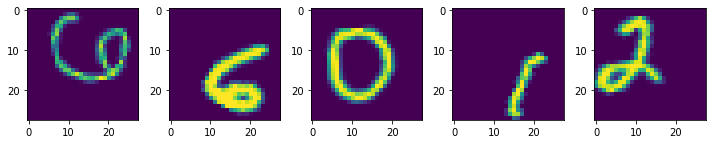

In [15]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img.squeeze(axis=-1))
        ax.axis('on')
    plt.tight_layout()
    plt.show()
plotImages(augmented_images)

# Parametric Model

### CNN based Deep Learning Model

Design time methodologies used:
* Using similar fasioned blocks of CNN.
* Using parameter learning conv2D instead of pooling layers.
* Increasing fasion of filters/channels down the layers.
* Batchnorms to add stability.
* Dropouts to regularize and learn unique features.
* Normal distribution in classification layer to speed up parameter learning.
* Relu / Selu activations for smoother gradient propagation.
* Adadelta optimization to account for 2nd order momentums while gradient descent and make use of auto adaptation to learning rate.
* Glorot initialization to consider layer dimentions while initializing.
* Lecun initializer and Alpha Dropouts for selu to maintain normalized inputs.
* Dropping down neural units from `Flatten layer` to directly classifier to have denser representation being classified directly.

In [0]:
def get_model():

  activation = 'relu'
  optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
  initializer = "glorot_normal"
  drop_prob = 0.5

  def ConvBlock(model, filters, kernel, strides=1, padding='valid'):
    model = Conv2D(filters, kernel_size=kernel, strides=strides, 
                   padding=padding, kernel_initializer=initializer)(model)
    model = BatchNormalization()(model)
    model = Activation(activation)(model)
    return model
  
  def Dropping(model):
    if activation == 'selu':
      model = AlphaDropout(drop_prob)(model)
    else:
      model = Dropout(drop_prob)(model)
    return model

  i = Input(shape=(28,28,1))

  m = ConvBlock(i, filters=32, kernel=3)
  m = ConvBlock(m, filters=32, kernel=3)
  m = ConvBlock(m, filters=32, kernel=5, strides=2, padding='same')
  m = Dropping(m)

  m = ConvBlock(m, filters=64, kernel=3)
  m = ConvBlock(m, filters=64, kernel=3)
  m = ConvBlock(m, filters=64, kernel=5, strides=2, padding='same')
  m = Dropping(m)

  m = ConvBlock(m, filters=128, kernel=4)
  m = Flatten()(m)
  m = Dropping(m)
  
  o = Dense(10, activation='softmax', kernel_initializer=initializer)(m)

  model = Model(i,o)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  return model

### Ensembling many models

In [0]:
models = []
num_models = 10
for _ in range(num_models):
  models.append(get_model())

Train time methodologies adopted:
* Ensembling using models with either relu activations or selu activations.
* Batch size 128 to have better approximation of gradients.
* Checkpointing at best loss over all the epochs instead of using early stopping with `patience` argument.
* Training and Validating on random subset of batches every epoch to give a regularization effect while also iterating through the epochs faster keeping in mind that the trade off is not much since the data samples are very much similar.

In [0]:
epochs = 200
batch_size = 128
hist = []

TQDM = TQDMNotebookCallback()

for i in tqdm(range(num_models), desc="Training several models"):

  checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(main_dir,'model_checkpoint') + '_' + str(i+6) + "_val_loss.h5",
                                         monitor='val_loss', verbose=0, save_best_only=True,
                                         save_weights_only=False, mode='auto', period=1)

  hist.append(
        models[i].fit(image_gen_train.flow(X_train, Y_train, batch_size=batch_size), 
                          steps_per_epoch=(X_train.shape[0]//batch_size)//4,  
                          validation_data=(X_valid, Y_valid),
                          validation_steps=(X_valid.shape[0]//batch_size)//4,
                          epochs=epochs,
                          verbose=0, 
                          workers=-1, use_multiprocessing=True,
                          callbacks=[
                                      checkpoint,
                                      TQDM,
                          ],
        )
  )
  print(models[i].evaluate(X_train, Y_train))
  print(models[i].evaluate(X_valid, Y_valid))

# Loading Trained Models

### Utility Function

In [0]:
def plot(X, Y, model):

  class metrics():
    def __init__(self, cm):
      self.cm = cm
      self.FP = cm.sum(axis=0) - np.diag(cm)  
      self.FN = cm.sum(axis=1) - np.diag(cm)
      self.TP = np.diag(cm)
      self.TN = cm.sum().sum() - (self.FP + self.FN + self.TP)
      self.N = self.FP + self.TN
      self.P = self.TP + self.FN
      self.T = self.TP + self.TN

    def FPR(self):
      # 1-specificity / fallout rate
      return self.FP/self.N

    def TPR(self):
      # sensitivity / recall
      return self.TP/self.P
    
    def Acc(self):
      Total = self.P + self.N
      return (self.T/Total)*100

  Y_pred = np.argmax(model.predict(X), axis=-1)
  confusion_matrix = tf.math.confusion_matrix(Y, Y_pred)
  classes=range(10)
  # confusion_matrix = tf.cast(tf.keras.utils.normalize(confusion_matrix), dtype='float16')
  df_cm = pd.DataFrame(confusion_matrix.numpy(), index=[i for i in classes],
                       columns=[i for i in classes])
  plt.figure(figsize=(3, 3), dpi=100)
  sns.heatmap(df_cm, annot=False, cmap="YlGnBu")
  plt.title('confusion matrix')
  plt.show()

  M = metrics(confusion_matrix.numpy())
  print("\nConfusion Matrix:")
  print(M.cm)
  print("\nAccuracy: ", M.Acc(), "%")
  print("\nFPR: ", M.FPR())
  print("\nTPR: ", M.TPR())

### Using Checkpoints

* Models 0-5: Use SeLU Activations
* Models 6-10: Use ReLU Activations

In [17]:
m = []
for i in range(11):
  m.append(tf.keras.models.load_model(
    filepath=os.path.join(main_dir, 'model_checkpoint_'+str(i)+'_val_loss.h5'), 
    custom_objects=None, compile=True
  ))
  print("Loaded Model",i)

Loaded Model 0
Loaded Model 1
Loaded Model 2
Loaded Model 3
Loaded Model 4
Loaded Model 5
Loaded Model 6
Loaded Model 7
Loaded Model 8
Loaded Model 9
Loaded Model 10


### Evaluating Metrics on Loaded Ccheckpoints (Individual Model Metrics)



 Model 0
Train: [0.5319531384604986, 0.982449]
Valid: [0.5361831027320592, 0.9835714]


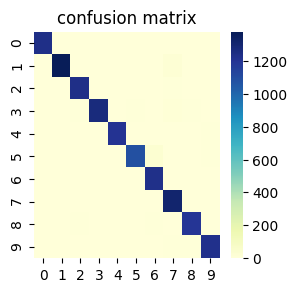


Confusion Matrix:
[[1239    0    0    0    0    0    1    0    0    0]
 [   0 1376    5    0    0    0    0   24    0    0]
 [   2    0 1240    0    0    0    0    7    4    0]
 [   0    0    7 1269    0    7    0   14    8    0]
 [   0    1    0    0 1205    0    2    4    1    9]
 [   1    4    0    1    0 1090   33    0    4    6]
 [   3    1    1    0    2    0 1234    0    0    0]
 [   0    0    2    0    1    0    0 1314    2    1]
 [   3    0    7    0    2    0    6    1 1197    3]
 [   5    0    0    0    5    0    0   10    7 1229]]

Accuracy:  [99.88095238 99.72222222 99.72222222 99.70634921 99.78571429 99.55555556
 99.61111111 99.47619048 99.61904762 99.63492063] %

FPR:  [1.23239437e-03 5.35953551e-04 1.93883846e-03 8.85347499e-05
 8.78889084e-04 6.10766949e-04 3.69750858e-03 5.31914894e-03
 2.28450927e-03 1.67489422e-03]

TPR:  [0.99919355 0.97935943 0.9896249  0.97241379 0.98608838 0.95697981
 0.99435939 0.99545455 0.98195242 0.97850318]


 Model 1
Train: [2.07261722314

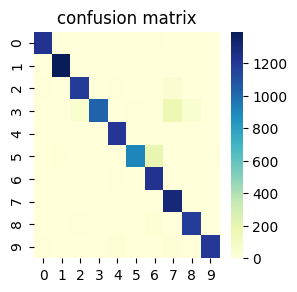


Confusion Matrix:
[[1233    0    0    0    0    0    7    0    0    0]
 [   0 1395    5    0    1    0    0    4    0    0]
 [  11    4 1183    0    7    0    2   43    3    0]
 [   1    4   52 1025    2   10    0  164   44    3]
 [   0    3    0    0 1214    0    0    1    0    4]
 [   4   13    0    0    1  909  197    1    4   10]
 [   1    2    0    0    6    0 1232    0    0    0]
 [   0    4    5    0    4    0    0 1307    0    0]
 [   1    2    6    0    5    0   22    1 1180    2]
 [   8    1    1    0   18    0    0   18    6 1204]]

Accuracy:  [99.73809524 99.65873016 98.8968254  97.77777778 99.58730159 98.0952381
 98.11904762 98.05555556 99.23809524 99.43650794] %

FPR:  [0.00228873 0.00294774 0.0060809  0.         0.00386711 0.00087252
 0.02007219 0.02056738 0.00500835 0.00167489]

TPR:  [0.99435484 0.99288256 0.94413408 0.78544061 0.99345336 0.79806848
 0.99274778 0.99015152 0.96800656 0.95859873]


 Model 2
Train: [1.4756949760850444, 0.95343536]
Valid: [1.3908902153197

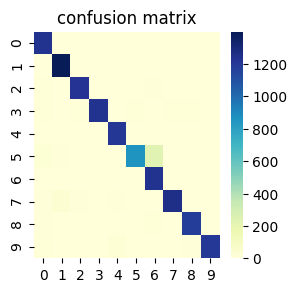


Confusion Matrix:
[[1237    0    0    0    0    0    3    0    0    0]
 [   0 1399    5    0    0    0    1    0    0    0]
 [  16    2 1221    0    0    0    9    4    1    0]
 [  11    2   13 1238    0   12    0   15   14    0]
 [   0    1    0    0 1213    0    5    0    0    3]
 [  28    6    1    0    0  858  240    0    3    3]
 [   1    1    0    0    1    0 1238    0    0    0]
 [   6   38    9    0    7    0    0 1259    1    0]
 [   9    1    4    0    3    0   15    1 1184    2]
 [  11    1    1    0   24    0    2    4    7 1206]]

Accuracy:  [99.32539683 99.53968254 99.48412698 99.46825397 99.65079365 97.67460317
 97.79365079 99.32539683 99.51587302 99.53968254] %

FPR:  [0.00721831 0.00464493 0.00290826 0.         0.00307611 0.00104703
 0.02420988 0.00212766 0.00228451 0.00070522]

TPR:  [0.99758065 0.99572954 0.97446129 0.948659   0.99263502 0.75329236
 0.99758259 0.95378788 0.97128794 0.96019108]


 Model 3
Train: [1.2811530386793513, 0.9429592]
Valid: [1.2536938034079

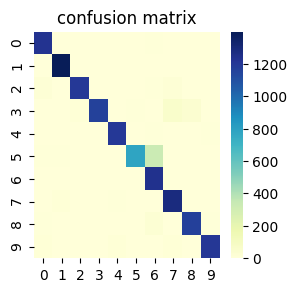


Confusion Matrix:
[[1233    0    0    0    0    0    7    0    0    0]
 [   2 1397    3    0    1    0    2    0    0    0]
 [  21    3 1201    0    1    0    9   17    1    0]
 [   2    5   15 1166    0    9    4   61   42    1]
 [   0    2    0    0 1203    0   10    0    0    7]
 [   9    9    1    1    0  781  330    0    3    5]
 [   0    1    0    0    0    0 1240    0    0    0]
 [   5   16    1    0    9    0    0 1286    1    2]
 [   6    3    2    0    3    0   28    3 1168    6]
 [  11    1    0    0   14    0    2   14    5 1209]]

Accuracy:  [99.5        99.61904762 99.41269841 98.88888889 99.62698413 97.08730159
 96.88095238 98.97619048 99.18253968 99.46031746] %

FPR:  [4.92957746e-03 3.57302367e-03 1.93883846e-03 8.85347499e-05
 2.46088944e-03 7.85271791e-04 3.45100801e-02 8.42198582e-03
 4.56901854e-03 1.85119887e-03]

TPR:  [0.99435484 0.99430605 0.9584996  0.89348659 0.98445172 0.6856892
 0.9991942  0.97424242 0.95816243 0.96257962]


 Model 4
Train: [0.508226403319

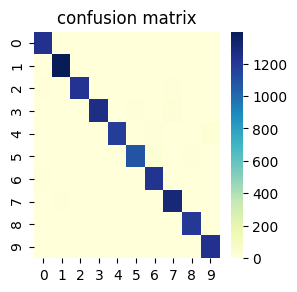


Confusion Matrix:
[[1238    0    0    0    0    0    1    0    1    0]
 [   0 1396    5    0    0    0    0    3    1    0]
 [  11    0 1226    0    0    0    5    8    3    0]
 [   0    2    3 1265    0    8    0   21    4    2]
 [   1    2    0    0 1179    0    7    1    0   32]
 [   1    3    1    1    0 1086   32    0   10    5]
 [   6    1    1    0    2    0 1230    0    1    0]
 [   0    7    3    0    4    0    0 1304    1    1]
 [   0    1    1    0    2    0    4    1 1205    5]
 [   3    1    1    0    1    0    0    4    5 1241]]

Accuracy:  [99.80952381 99.79365079 99.66666667 99.67460317 99.58730159 99.51587302
 99.52380952 99.57142857 99.68253968 99.52380952] %

FPR:  [1.93661972e-03 1.51853506e-03 1.32193531e-03 8.85347499e-05
 7.91000176e-04 6.98019370e-04 4.31376001e-03 3.36879433e-03
 2.28450927e-03 3.96685472e-03]

TPR:  [0.9983871  0.99359431 0.97845172 0.96934866 0.96481178 0.95346795
 0.99113618 0.98787879 0.98851518 0.98805732]


 Model 5
Train: [1.21323747667

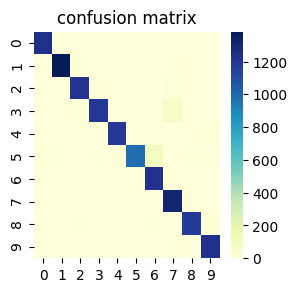


Confusion Matrix:
[[1238    0    0    0    0    0    2    0    0    0]
 [   2 1382    6    0    0    0    0   14    1    0]
 [   8    1 1220    0    0    0    1   21    2    0]
 [   4    0   13 1203    0    2    0   79    2    2]
 [   1    1    0    0 1197    0    1    4    0   18]
 [  14    6    1    6    0  978  111    5   12    6]
 [   9    2    0    0    2    0 1228    0    0    0]
 [   0    0    1    0    2    0    0 1316    0    1]
 [  10    0   10    0    2    0    6    4 1172   15]
 [   6    0    0    0    3    0    0   13    3 1231]]

Accuracy:  [99.55555556 99.73809524 99.49206349 99.14285714 99.73015873 98.70634921
 98.93650794 98.85714286 99.46825397 99.46825397] %

FPR:  [0.00475352 0.00089326 0.002732   0.00053121 0.000791   0.0001745
 0.01065235 0.01241135 0.00175731 0.0037024 ]

TPR:  [0.9983871  0.98362989 0.97366321 0.92183908 0.97954173 0.85864794
 0.98952458 0.9969697  0.96144381 0.98009554]


 Model 6
Train: [0.0198749081239652, 0.9947279]
Valid: [0.02832101144009

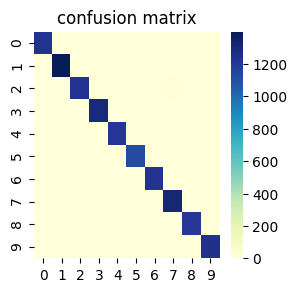


Confusion Matrix:
[[1239    0    0    0    0    0    0    0    0    1]
 [   0 1399    2    0    0    0    0    4    0    0]
 [   1    0 1237    2    0    0    0   11    2    0]
 [   0    0    0 1297    0    5    0    2    1    0]
 [   1    0    0    0 1216    0    0    0    0    5]
 [   0    1    0    1    0 1129    2    0    3    3]
 [   2    2    0    0    3    1 1231    0    2    0]
 [   0    2    0    0    1    0    0 1315    1    1]
 [   0    2    2    0    4    1    0    1 1205    4]
 [   1    0    0    0    4    1    0    3    1 1246]]

Accuracy:  [99.95238095 99.8968254  99.84126984 99.91269841 99.85714286 99.85714286
 99.9047619  99.79365079 99.80952381 99.80952381] %

FPR:  [0.00044014 0.00062528 0.00035252 0.0002656  0.00105467 0.00069802
 0.00017607 0.0018617  0.00087866 0.00123413]

TPR:  [0.99919355 0.99572954 0.98723065 0.99386973 0.99509002 0.99122037
 0.99194198 0.99621212 0.98851518 0.99203822]


 Model 7
Train: [0.020647995247388473, 0.9939796]
Valid: [0.02890773485

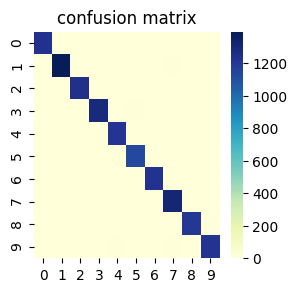


Confusion Matrix:
[[1238    0    0    0    0    0    2    0    0    0]
 [   0 1395    0    0    0    0    0   10    0    0]
 [   0    0 1246    0    0    1    0    3    3    0]
 [   0    1    0 1293    0    7    0    3    1    0]
 [   0    1    0    0 1218    0    0    0    1    2]
 [   1    0    0    1    0 1131    2    0    3    1]
 [   0    2    0    0    2    0 1235    0    2    0]
 [   0    1    1    0    2    0    0 1316    0    0]
 [   0    3    3    1    1    2    0    0 1206    3]
 [   1    0    2    0    8    1    0    9    4 1231]]

Accuracy:  [99.96825397 99.85714286 99.8968254  99.88888889 99.86507937 99.84920635
 99.92063492 99.76984127 99.78571429 99.75396825] %

FPR:  [0.00017606 0.0007146  0.00052877 0.00017707 0.00114256 0.00095978
 0.00035214 0.00221631 0.00123012 0.00052891]

TPR:  [0.9983871  0.99288256 0.99441341 0.9908046  0.99672668 0.99297629
 0.99516519 0.9969697  0.98933552 0.98009554]


 Model 8
Train: [0.021853088483970794, 0.99404764]
Valid: [0.0298957611

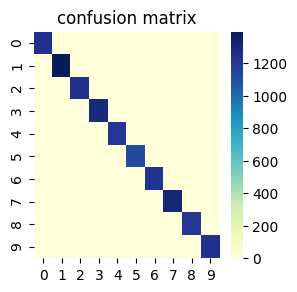


Confusion Matrix:
[[1239    0    0    0    0    0    1    0    0    0]
 [   0 1395    2    0    0    1    0    7    0    0]
 [   0    0 1247    0    2    0    0    3    1    0]
 [   0    0    1 1294    0    8    0    1    1    0]
 [   1    0    0    0 1211    0    0    2    1    7]
 [   1    0    0    2    0 1132    3    0    0    1]
 [   1    2    1    0    2    2 1233    0    0    0]
 [   0    2    1    0    1    0    0 1316    0    0]
 [   1    1    4    0    2    2    2    0 1205    2]
 [   2    0    2    0    4    1    0    7    3 1237]]

Accuracy:  [99.94444444 99.88095238 99.86507937 99.8968254  99.82539683 99.83333333
 99.88888889 99.80952381 99.84126984 99.76984127] %

FPR:  [0.00052817 0.00044663 0.00096942 0.00017707 0.00096678 0.00122153
 0.00052822 0.00177305 0.00052719 0.00088152]

TPR:  [0.99919355 0.99288256 0.99521149 0.99157088 0.99099836 0.99385426
 0.99355359 0.9969697  0.98851518 0.98487261]


 Model 9
Train: [0.020386090367475202, 0.99465984]
Valid: [0.0270716623

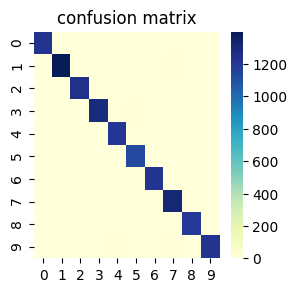


Confusion Matrix:
[[1238    0    0    0    0    0    2    0    0    0]
 [   0 1399    0    0    0    0    0    6    0    0]
 [   1    0 1248    0    1    0    0    2    1    0]
 [   0    1    4 1294    0    6    0    0    0    0]
 [   0    0    0    0 1217    0    1    2    0    2]
 [   1    0    0    1    1 1132    2    0    1    1]
 [   2    2    2    0    2    0 1231    0    2    0]
 [   0    3    3    0    1    0    0 1313    0    0]
 [   1    2    5    1    2    3    4    0 1199    2]
 [   1    0    2    0    7    1    0    6    4 1235]]

Accuracy:  [99.93650794 99.88888889 99.83333333 99.8968254  99.84920635 99.86507937
 99.84920635 99.81746032 99.77777778 99.79365079] %

FPR:  [0.00052817 0.0007146  0.00141006 0.00017707 0.00123044 0.00087252
 0.00079232 0.00141844 0.00070293 0.00044076]

TPR:  [0.9983871  0.99572954 0.99600958 0.99157088 0.99590835 0.99385426
 0.99194198 0.99469697 0.98359311 0.98328025]


 Model 10
Train: [0.020741430156225774, 0.9944218]
Valid: [0.0275516565

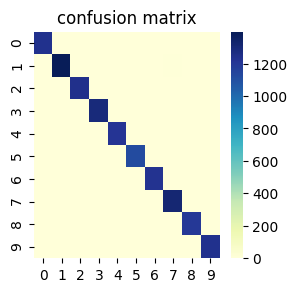


Confusion Matrix:
[[1240    0    0    0    0    0    0    0    0    0]
 [   0 1396    2    0    0    0    0    7    0    0]
 [   1    0 1247    1    2    0    0    1    1    0]
 [   0    0    0 1297    0    4    0    4    0    0]
 [   0    0    0    0 1218    0    1    0    0    3]
 [   0    0    0    0    1 1128    5    1    3    1]
 [   3    1    1    0    3    0 1231    0    2    0]
 [   0    2    1    0    2    0    0 1315    0    0]
 [   1    1    2    1    5    1    0    1 1204    3]
 [   2    0    1    0    4    2    0    3    2 1242]]

Accuracy:  [99.94444444 99.8968254  99.8968254  99.92063492 99.83333333 99.85714286
 99.87301587 99.82539683 99.81746032 99.83333333] %

FPR:  [0.0006162  0.0003573  0.0006169  0.00017707 0.00149411 0.00061077
 0.00052822 0.00150709 0.00070293 0.00061707]

TPR:  [1.         0.99359431 0.99521149 0.99386973 0.99672668 0.99034241
 0.99194198 0.99621212 0.98769483 0.9888535 ]


In [99]:
for i in range(11):  
  print('\n\n Model',i)
  print('Train:', m[i].evaluate(X_train, Y_train, verbose=0))
  print('Valid:', m[i].evaluate(X_valid, Y_valid, verbose=0))
  plot(X_valid, Y_valid, m[i])

### Ensemble Scores on Train and Valid

* Using only ReLU activation Models as they perform better.

##### Training Split Scores

Peak into predictions
Model 6 : [5 2 5 ... 1 3 1]
Model 7 : [5 2 5 ... 1 3 1]
Model 8 : [5 2 5 ... 1 3 1]
Model 9 : [5 2 5 ... 1 3 1]
Model 10 : [5 2 5 ... 1 3 1]


Train Metrics:


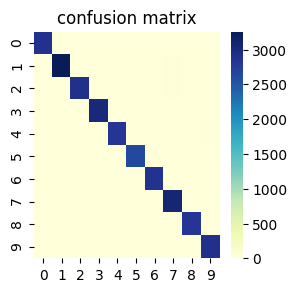


Confusion Matrix:
[[2891    0    0    0    0    0    1    0    0    0]
 [   0 3257    1    0    4    0    0   15    2    0]
 [   3    3 2902    0    1    0    0   15    0    0]
 [   0    0    2 3031    0    3    0    4    4    2]
 [   0    2    0    0 2830    0    0    2    0   16]
 [   0    0    0    1    1 2639   11    1    1    2]
 [   3    0    0    1    5    4 2881    0    2    0]
 [   0    1    6    0    4    0    0 3069    0    1]
 [   1    1    2    1    2    2    3    1 2828    3]
 [   3    0    0    0   10    2    0    5    4 2908]]

Accuracy:  [99.96258503 99.90136054 99.8877551  99.93877551 99.84013605 99.9047619
 99.89795918 99.81292517 99.90136054 99.83673469] %

FPR:  [0.00037724 0.00026798 0.00041547 0.00011383 0.00101695 0.00041131
 0.00056595 0.0016338  0.00048953 0.00090676]

TPR:  [0.99965422 0.99329064 0.99247606 0.99507551 0.99298246 0.9935994
 0.99482044 0.99610516 0.99437412 0.99181446]


Training Overall Accuracy: 0.9959863945578231


In [108]:
pred = np.zeros((X_train.shape[0],10))

print("Peak into predictions")
for i in range(6,11):
  pred += m[i].predict(X_train)
  print("Model",i,":",np.argmax(pred, axis=-1))

pred = np.argmax(pred, axis=-1)
print("\n\nTrain Metrics:")
plot(X_train, Y_train, m[i])
print("\n\nTraining Overall Accuracy:", accuracy_score(Y_train,pred))

##### Validation Split Scores

Peak into predictions
Model 6 : [6 9 3 ... 3 8 5]
Model 7 : [6 9 3 ... 3 8 5]
Model 8 : [6 9 3 ... 3 8 5]
Model 9 : [6 9 3 ... 3 8 5]
Model 10 : [6 9 3 ... 3 8 5]


Validation Metrics:


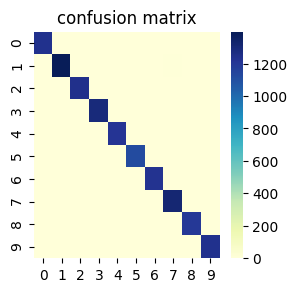


Confusion Matrix:
[[1240    0    0    0    0    0    0    0    0    0]
 [   0 1396    2    0    0    0    0    7    0    0]
 [   1    0 1247    1    2    0    0    1    1    0]
 [   0    0    0 1297    0    4    0    4    0    0]
 [   0    0    0    0 1218    0    1    0    0    3]
 [   0    0    0    0    1 1128    5    1    3    1]
 [   3    1    1    0    3    0 1231    0    2    0]
 [   0    2    1    0    2    0    0 1315    0    0]
 [   1    1    2    1    5    1    0    1 1204    3]
 [   2    0    1    0    4    2    0    3    2 1242]]

Accuracy:  [99.94444444 99.8968254  99.8968254  99.92063492 99.83333333 99.85714286
 99.87301587 99.82539683 99.81746032 99.83333333] %

FPR:  [0.0006162  0.0003573  0.0006169  0.00017707 0.00149411 0.00061077
 0.00052822 0.00150709 0.00070293 0.00061707]

TPR:  [1.         0.99359431 0.99521149 0.99386973 0.99672668 0.99034241
 0.99194198 0.99621212 0.98769483 0.9888535 ]


Validation Overall Accuracy: 0.9941269841269841


In [106]:
pred = np.zeros((X_valid.shape[0],10))

print("Peak into predictions")
for i in range(6,11):
  pred += m[i].predict(X_valid)
  print("Model",i,":",np.argmax(pred, axis=-1))

pred = np.argmax(pred, axis=-1)
print("\n\nValidation Metrics:")
plot(X_valid, Y_valid, m[i])

print("\n\nValidation Overall Accuracy:", accuracy_score(Y_valid,pred))